# NLP_HSE

## Импорты

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

import re
!pip install pymorphy2
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from nltk.corpus import stopwords

from multiprocessing import Pool
from tqdm import tqdm

import nltk
nltk.download('stopwords')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.8 MB/s 
     |████████████████████████████████| 8.2 MB 29.4 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=713d6361d2adbe698eb5eb979fc437243bcebc90b4a74d976320d996f10af51d
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [ ]:
from keras import backend as K


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Загрузка данных и предпросмотр

In [3]:
train = pd.read_csv("/content/drive/My Drive/nlp_hse/train_dl.csv")

In [4]:
test = pd.read_csv("/content/drive/My Drive/nlp_hse/new_test_dl.csv")

In [5]:
train.head()

,bank,feeds,grades,date
0,unicreditbank,Я очень редко пользуюсь банковскими продуктами...,5.0,31.12.2017 18:20
1,fk_otkritie,Я вместе с женой 15.11.2019 обратился в отделе...,1.0,22.11.2019 22:42
2,alfabank,Добрый день.Сегодня 27.12.2018 г около 15.40-1...,1.0,27.12.2018 23:20
3,vtb,"""Где карточку открывали, туда и идите..."" - эт...",2.0,05.02.2020 16:40
4,promsvyazbank,При покупках в iTunes списываются завышенные с...,NaN,26.02.2016 15:48


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350000 entries, 0 to 349999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   bank    350000 non-null  object 
 1   feeds   350000 non-null  object 
 2   grades  240250 non-null  float64
 3   date    350000 non-null  object 
dtypes: float64(1), object(3)
memory usage: 10.7+ MB


In [6]:
train['grades'].value_counts()

1.0    129814
5.0     66408
2.0     25803
3.0     11131
4.0      7094
Name: grades, dtype: int64

In [ ]:
test.head()

,Unnamed: 0,bank,feeds,date
0,0,sberbank,История такова: 27.01.2015 мне на телефон приш...,05.02.2015 17:33
1,1,alfabank,"Нельзя решить ни один вопрос оперативно, автоо...",03.03.2021 9:27
2,2,tcs,"Быстро, удобно, чего ещё нужно то. На сайтике ...",09.04.2018 7:40
3,3,pochtabank,Добрый день! Просто в шоке от ПАО «Почта Банк...,09.04.2020 9:57
4,4,sberbank,В течение выходных дней новогоднего периода 20...,12.01.2012 14:00


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34114 entries, 0 to 34113
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  34114 non-null  int64 
 1   bank        34114 non-null  object
 2   feeds       34114 non-null  object
 3   date        34114 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.0+ MB


## EDA

### Пропуски

In [7]:
train.query('grades!=grades')

,bank,feeds,grades,date
4,promsvyazbank,При покупках в iTunes списываются завышенные с...,NaN,26.02.2016 15:48
6,otpbank,06.06.2016 по платежному поручению №916 через ...,NaN,16.09.2016 10:55
7,homecreditbank,Всем доброго времени суток! С банком в принцип...,NaN,15.03.2017 22:12
20,otpbank,"Имея кредитную карту в ОТП банке, ушла в декре...",NaN,19.07.2017 16:19
23,alfabank,"Здравствуйте! После нескольких переводов, на с...",NaN,19.02.2019 8:33
...,...,...,...,...
349990,mkb,Решили мы с женой взять потребительский кредит...,NaN,27.03.2018 10:50
349991,raiffeisen,"Так как сам в возникшем вопросе разобрался, то...",NaN,07.04.2009 18:25
349993,qiwibank,Заблокировали кошелёк 07.11.2019. на кошельке ...,NaN,08.11.2019 7:31
349998,tcs,"Просрочил платеж на 5 дней, а мне уже взыскани...",NaN,24.11.2020 23:39


Пока что дропнем пропуски, потом придумаем, как их предобработать

In [8]:
train = train.dropna()

In [9]:
train = train.astype({'grades': 'int32'})

### Обработка текста

In [11]:
m = MorphAnalyzer()
regex = re.compile("[А-Яа-яA-z()?!.,]+")

def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

@lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]


mystopwords = stopwords.words('russian') 
def remove_stopwords(lemmas, stopwords = mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)
    
    return ' '.join(remove_stopwords(lemmas))

In [12]:
with Pool(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, train['feeds']), total=len(train)))
    
train['lemmas'] = lemmas
train.sample(5)

100%|██████████| 240250/240250 [1:41:34<00:00, 39.42it/s]


,bank,feeds,grades,date,lemmas
23204,sberbank,Хочу выразить огромную благодарность сотрудник...,5,20.04.2016 8:15,хотеть выразить огромный благодарность сотрудн...
12441,rsb,В ноябре 2014 г. пытался получить доступ к моб...,1,08.05.2015 13:52,ноябрь пытаться получить доступ мобильный банк...
233582,sberbank,Добрый день. Начну с самого начала. Случилась ...,1,20.11.2020 17:05,добрый день. начать начала. случиться жизнь не...
293960,pochtabank,"Хочу поделиться своей историей, которая меня з...",5,21.03.2019 18:54,"хотеть поделиться свой историей, который заста..."
235201,sovcombank,Не первый год пользуюсь услугами Совкомбанка. ...,5,12.10.2019 18:00,первый пользоваться услуга совкомбанка. делать...


In [14]:
with Pool(4) as p:
    lemmas_test = list(tqdm(p.imap(clean_text, test['feeds']), total=len(test)))
test['lemmas'] = lemmas_test
test.sample(5)

100%|██████████| 34114/34114 [14:52<00:00, 38.22it/s]


,Unnamed: 0,bank,feeds,date,lemmas
20316,20316,raiffeisen,У меня в Вашем банке зарплатная карта. Все вро...,22.10.2013 11:26,банк зарплатный карта. вроде устраивать банком...
27720,27720,sberbank,Расскажу свой опыт обращения в Сбербанк. Нам п...,30.07.2014 20:48,рассказать свой опыт обращение сбербанк. понад...
29452,29452,raiffeisen,Обратился в отделение Банка с просьбой отключи...,13.09.2019 1:20,обратиться отделение банк просьба отключить ст...
32675,32675,sberbank,"Со Сбербанком общаюсь давно, четвертый год пол...",23.12.2014 14:20,"сбербанк общаться давно, четвёртый получать за..."
25542,25542,sovcombank,Добрый день!До конца 2018 года являлся счастли...,05.09.2019 14:59,добрый день!дый конец являться счастливый обла...


In [13]:
train.to_csv('train.csv', index=False)

In [15]:
test.to_csv('test.csv', index=False)

In [16]:
!cp 'train.csv' '/content/drive/MyDrive/nlp_hse/'

In [17]:
!cp 'test.csv' '/content/drive/MyDrive/nlp_hse/'

## ML

In [4]:
train = pd.read_csv("/content/drive/My Drive/nlp_hse/train.csv")

In [6]:
test = pd.read_csv("/content/drive/My Drive/nlp_hse/test.csv")

In [8]:
# Максимальное количество слов 
num_words = 10000
# Максимальная длина отзыва
max_news_len = 1000
# Количество классов отзывов
nb_classes = 5

In [9]:
text = train['lemmas']
text

0         очень редко пользоваться банковский продуктами...
1         вместе жена обратиться отделение банк открытие...
2         добрый день.сегодня около банкомат адрес рязан...
3         карточка открывали, туда идите... фраза давно ...
4         оформить кредит наличные отделение почта банка...
                                ...                        
240245    являться зарплатник сбербанка, поэтому выбор б...
240246    открывать первый расчётный счёт различный банк...
240247    хотеть поделиться свой положительный опыт полу...
240248    добрый день!хотеть оставить отзыв банк юникред...
240249    добрый дня! обратиться локо банк просьба рестр...
Name: lemmas, Length: 240250, dtype: object

In [10]:
y_train = utils.to_categorical(train['grades'] - 1, nb_classes)
y_train

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

### Токенизация

In [23]:
tokenizer = Tokenizer(num_words=num_words, filters='\t\n')

In [24]:
tokenizer.fit_on_texts(text)

Словарь токенизатора

In [25]:
tokenizer.word_index

{'банк': 1,
 'карта': 2,
 'который': 3,
 'сотрудник': 4,
 'кредит': 5,
 'свой': 6,
 'деньга': 7,
 'отделение': 8,
 'мочь': 9,
 'день': 10,
 'кредитный': 11,
 'клиент': 12,
 'сумма': 13,
 'очень': 14,
 'весь': 15,
 'счёт': 16,
 'получить': 17,
 'вопрос': 18,
 'время': 19,
 'заявление': 20,
 'дать': 21,
 'договор': 22,
 'офис': 23,
 'ответ': 24,
 'обратиться': 25,
 'решить': 26,
 'хотеть': 27,
 'заявка': 28,
 'позвонить': 29,
 'банка,': 30,
 'прийти': 31,
 'данный': 32,
 'номер': 33,
 'написать': 34,
 'звонить': 35,
 'сказать': 36,
 'платёж': 37,
 'сбербанк': 38,
 'должный': 39,
 'просто': 40,
 'документ': 41,
 'услуга': 42,
 'месяц': 43,
 'средство': 44,
 'оформить': 45,
 'работа': 46,
 'срок': 47,
 'обращение': 48,
 'почему': 49,
 'проблема': 50,
 'большой': 51,
 'телефон': 52,
 'условие': 53,
 'работать': 54,
 'сделать': 55,
 'менеджер': 56,
 'звонок': 57,
 'информация': 58,
 'новый': 59,
 'нужно': 60,
 'являться': 61,
 'банка.': 62,
 'никакой': 63,
 'обслуживание': 64,
 'первый': 65,

Преобразуем в числовое представление

In [26]:
sequences = tokenizer.texts_to_sequences(text)

In [27]:
index = 2
print(news[index])
print(sequences[index])

добрый день.сегодня около банкомат адрес рязанский пр.д. корп разный разности) вносить деньга счёт дебетовый карта рублей) банкомат деньга принял, начать жужжать, пересчитывать деньга думать выдать ошибка написать ошибка, ждать возврат принять купюра усиленно думать жужжать время появиться обычный меню. вернуть карту.позвонить контакт центр оставить обращение сообщить номер банкомат время, дать местонахождение банкомата. обещать течение день разобраться. хотеться разобраться значит ответить обращение? день иметь неосторожность запихать банкомат иметься денежный средства.просить разобраться вернуть денежный средство который ушли, карточка дойти застрять банкомате.
[90, 254, 72, 129, 7274, 294, 437, 7, 16, 138, 2, 3733, 72, 7, 3983, 230, 4662, 7, 322, 117, 228, 34, 1980, 81, 211, 118, 894, 322, 19, 457, 734, 127, 652, 130, 171, 48, 196, 33, 72, 406, 21, 8584, 3643, 278, 69, 10, 2810, 220, 224, 830, 132, 10, 99, 5673, 72, 534, 84, 224, 127, 84, 44, 3, 6307, 593, 1184, 4932, 3009]


Ограничиваем длину

In [29]:
x_train = pad_sequences(sequences, maxlen=max_news_len)

In [30]:
x_train[:5]

array([[   0,    0,    0, ...,   64,  115, 9498],
       [   0,    0,    0, ...,  421, 1440, 5835],
       [   0,    0,    0, ..., 1184, 4932, 3009],
       [   0,    0,    0, ..., 1157,  151, 4769],
       [   0,    0,    0, ...,  172, 2749,  921]], dtype=int32)

### Метрика

Чтобы обучать на F1 реализуем эту метрику



In [32]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Свёрточная нейросеть

In [31]:
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 32, input_length=max_news_len))
model_cnn.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(5, activation='softmax'))

In [33]:
model_cnn.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=[f1])

In [34]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 32)          320000    
                                                                 
 conv1d (Conv1D)             (None, 996, 250)          40250     
                                                                 
 global_max_pooling1d (Globa  (None, 250)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               32128     
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 393,023
Trainable params: 393,023
Non-trainable params: 0
__________________________________________________

In [35]:
model_cnn_save_path = 'best_model_cnn.h5'
checkpoint_callback_cnn = ModelCheckpoint(model_cnn_save_path, 
                                      monitor='val_f1',
                                      save_best_only=True,
                                      verbose=1)

In [36]:
history_cnn = model_cnn.fit(x_train, 
                            y_train, 
                            epochs=5,
                            batch_size=128,
                            validation_split=0.1,
                            callbacks=[checkpoint_callback_cnn])

Epoch 1/5
1690/1690 [==============================] - ETA: 0s - loss: 0.6959 - f1: 0.7671
Epoch 1: val_f1 improved from inf to 0.79003, saving model to best_model_cnn.h5
1690/1690 [==============================] - 56s 28ms/step - loss: 0.6959 - f1: 0.7671 - val_loss: 0.6400 - val_f1: 0.7900
Epoch 2/5
1689/1690 [============================>.] - ETA: 0s - loss: 0.6034 - f1: 0.7975
Epoch 2: val_f1 did not improve from 0.79003
1690/1690 [==============================] - 48s 28ms/step - loss: 0.6034 - f1: 0.7975 - val_loss: 0.6374 - val_f1: 0.7910
Epoch 3/5
1689/1690 [============================>.] - ETA: 0s - loss: 0.5559 - f1: 0.8075
Epoch 3: val_f1 improved from 0.79003 to 0.78451, saving model to best_model_cnn.h5
1690/1690 [==============================] - 48s 28ms/step - loss: 0.5559 - f1: 0.8075 - val_loss: 0.6593 - val_f1: 0.7845
Epoch 4/5
1689/1690 [============================>.] - ETA: 0s - loss: 0.5018 - f1: 0.8195
Epoch 4: val_f1 did not improve from 0.78451
1690/1690 [==

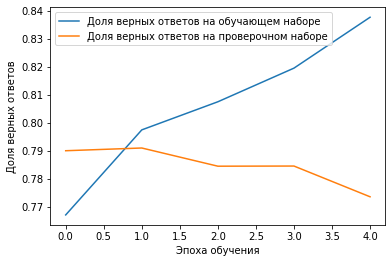

In [37]:
plt.plot(history_cnn.history['f1'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_f1'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

### Cеть LSTM

In [38]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 32, input_length=max_news_len))
model_lstm.add(LSTM(16))
model_lstm.add(Dense(5, activation='softmax'))

In [39]:
model_lstm.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=[f1])

In [40]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 32)          320000    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 5)                 85        
                                                                 
Total params: 323,221
Trainable params: 323,221
Non-trainable params: 0
_________________________________________________________________


Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`

In [41]:
model_lstm_save_path = 'best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path, 
                                      monitor='val_f1',
                                      save_best_only=True,
                                      verbose=1)

In [42]:
history_lstm = model_lstm.fit(x_train, 
                              y_train, 
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/5
1690/1690 [==============================] - ETA: 0s - loss: 0.7140 - f1: 0.7606
Epoch 1: val_f1 improved from inf to 0.78792, saving model to best_model_lstm.h5
1690/1690 [==============================] - 62s 35ms/step - loss: 0.7140 - f1: 0.7606 - val_loss: 0.6512 - val_f1: 0.7879
Epoch 2/5
1690/1690 [==============================] - ETA: 0s - loss: 0.6270 - f1: 0.7932
Epoch 2: val_f1 did not improve from 0.78792
1690/1690 [==============================] - 57s 34ms/step - loss: 0.6270 - f1: 0.7932 - val_loss: 0.6446 - val_f1: 0.7892
Epoch 3/5
1689/1690 [============================>.] - ETA: 0s - loss: 0.6021 - f1: 0.7978
Epoch 3: val_f1 improved from 0.78792 to 0.78685, saving model to best_model_lstm.h5
1690/1690 [==============================] - 57s 34ms/step - loss: 0.6022 - f1: 0.7978 - val_loss: 0.6431 - val_f1: 0.7869
Epoch 4/5
1689/1690 [============================>.] - ETA: 0s - loss: 0.5798 - f1: 0.8014
Epoch 4: val_f1 improved from 0.78685 to 0.78671, saving

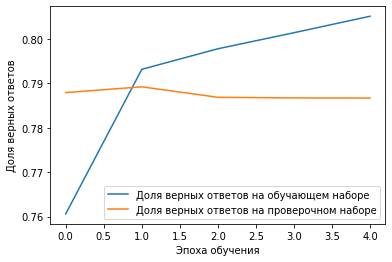

In [43]:
plt.plot(history_lstm.history['f1'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_f1'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

### Сеть GRU

In [44]:
model_gru = Sequential()
model_gru.add(Embedding(num_words, 32, input_length=max_news_len))
model_gru.add(GRU(16))
model_gru.add(Dense(5, activation='softmax'))

In [45]:
model_gru.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=[f1])

In [46]:
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1000, 32)          320000    
                                                                 
 gru (GRU)                   (None, 16)                2400      
                                                                 
 dense_3 (Dense)             (None, 5)                 85        
                                                                 
Total params: 322,485
Trainable params: 322,485
Non-trainable params: 0
_________________________________________________________________


In [47]:
model_gru_save_path = 'best_model_gru.h5'
checkpoint_callback_gru = ModelCheckpoint(model_gru_save_path, 
                                      monitor='val_f1',
                                      save_best_only=True,
                                      verbose=1)

In [48]:
history_gru = model_gru.fit(x_train, 
                              y_train, 
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_gru])

Epoch 1/5
1690/1690 [==============================] - ETA: 0s - loss: 0.7226 - f1: 0.7455
Epoch 1: val_f1 improved from inf to 0.78813, saving model to best_model_gru.h5
1690/1690 [==============================] - 64s 37ms/step - loss: 0.7226 - f1: 0.7455 - val_loss: 0.6493 - val_f1: 0.7881
Epoch 2/5
1690/1690 [==============================] - ETA: 0s - loss: 0.6237 - f1: 0.7946
Epoch 2: val_f1 did not improve from 0.78813
1690/1690 [==============================] - 57s 34ms/step - loss: 0.6237 - f1: 0.7946 - val_loss: 0.6425 - val_f1: 0.7896
Epoch 3/5
1689/1690 [============================>.] - ETA: 0s - loss: 0.6041 - f1: 0.7980
Epoch 3: val_f1 did not improve from 0.78813
1690/1690 [==============================] - 55s 33ms/step - loss: 0.6041 - f1: 0.7980 - val_loss: 0.6400 - val_f1: 0.7893
Epoch 4/5
1689/1690 [============================>.] - ETA: 0s - loss: 0.5854 - f1: 0.8015
Epoch 4: val_f1 did not improve from 0.78813
1690/1690 [==============================] - 54s 32m

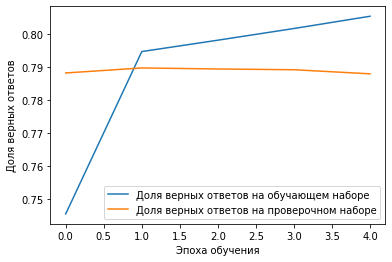

In [49]:
plt.plot(history_gru.history['f1'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_gru.history['val_f1'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Тестирование

In [ ]:
test_sequences = tokenizer.texts_to_sequences(valid['feeds'])

In [ ]:
x_test = pad_sequences(test_sequences, maxlen=max_news_len)
x_test[:5]

array([[   0,    0,    0, ...,  236,    1, 1800],
       [   0,    0,    0, ...,    1, 4777,  215],
       [   0,    0,    0, ...,   20,    3,  464],
       [   0,    0,    0, ...,    8, 1063,  748],
       [   0,    0,    0, ..., 3217,  283, 9226]], dtype=int32)

In [ ]:
y_test = utils.to_categorical(valid['grades'] - 1, nb_classes)
y_test

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

### Одномерная свёрточная сеть

In [ ]:
model_cnn.load_weights(model_cnn_save_path)

In [ ]:
model_cnn.evaluate(x_test, y_test, verbose=1)

1877/1877 [==============================] - 9s 5ms/step - loss: 0.7632 - f1: 0.7814


[0.7631576657295227, 0.7813660502433777]

### Сеть LSTM

In [ ]:
model_lstm.load_weights(model_lstm_save_path)

In [ ]:
model_lstm.evaluate(x_test, y_test, verbose=1)

1877/1877 [==============================] - 28s 15ms/step - loss: 0.6417 - f1: 0.7905


[0.6416573524475098, 0.7905296683311462]

### Сеть GRU

In [ ]:
model_gru.load_weights(model_gru_save_path)

In [ ]:
model_gru.evaluate(x_test, y_test, verbose=1)

1877/1877 [==============================] - 28s 15ms/step - loss: 0.6404 - f1: 0.7897


[0.6404411792755127, 0.789726972579956]

## Сохранение результата

In [50]:
final_sequences = tokenizer.texts_to_sequences(test['lemmas'])

In [51]:
x_final = pad_sequences(final_sequences, maxlen=max_news_len)
x_final[:5]

array([[   0,    0,    0, ...,   17,   21,  256],
       [   0,    0,    0, ...,  293,  390, 2321],
       [   0,    0,    0, ..., 2383,  516, 7174],
       [   0,    0,    0, ...,  430,  471,  305],
       [   0,    0,    0, ..., 2467,   99, 1243]], dtype=int32)

In [52]:
model_gru.load_weights(model_gru_save_path)

In [53]:
predict_x=model_gru.predict(x_final) 
classes_x=np.argmax(predict_x,axis=1)
classes_x

1067/1067 [==============================] - 15s 13ms/step


array([0, 0, 4, ..., 0, 0, 0])

In [54]:
sol = pd.DataFrame({'inds': test.index,
                    'grades': classes_x})
sol

,inds,grades
0,0,0
1,1,0
2,2,4
3,3,0
4,4,0
...,...,...
34109,34109,0
34110,34110,0
34111,34111,0
34112,34112,0


In [55]:
sol['grades'].value_counts()

0    23310
4     9980
2      339
1      306
3      179
Name: grades, dtype: int64

In [56]:
sol['grades'] = sol['grades'].apply(lambda x: x+1)

In [57]:
sol

,inds,grades
0,0,1
1,1,1
2,2,5
3,3,1
4,4,1
...,...,...
34109,34109,1
34110,34110,1
34111,34111,1
34112,34112,1


In [58]:
sol['grades'].value_counts()

1    23310
5     9980
3      339
2      306
4      179
Name: grades, dtype: int64

In [59]:
sol.to_csv('submission.csv', index=False)